In [1]:
# import matplotlib.pyplot as plt
import pyspark.sql.functions as f
from gentropy.common.session import Session
from gentropy.common.spark_helpers import order_array_of_structs_by_field
from gentropy.dataset.ld_index import LDIndex
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.study_locus import StudyLocus
from gentropy.method.susie_inf import SUSIE_inf


Loading BokehJS ...

In [2]:
session = Session(
    extended_spark_conf={
        "spark.driver.memory": "10g",
        "spark.executor.memory": "10g",
    },
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/07/25 14:45:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Context
UKB-PPP summary statistics were ingested, a deduplication and sanity filter was run on harmonised summary statistics prior to clumping
Locus breaker clumping was performed on the resulting studies

Parameters:  
 lbc_baseline_pvalue: 1e-5,  
 lbc_distance_cutoff: 250_000,  
 lbc_pvalue_threshold: 1e-8,  
 lbc_flanking_distance: 100_000,  
 large_loci_size: 1_500_000,  
 wbc_clump_distance: 500_000,  
 wbc_pvalue_threshold: 1e-8,  
 collect_locus: bool = True,  
 remove_mhc: bool = True,

Loci with less than 100 variants, or more than 15,000, were filtered out and fine-mapped with PICS.


In [3]:
study_index = StudyIndex.from_parquet(
    session, "/Users/dc16/data/study_index/ukb_ppp/"
)
ld_index = LDIndex.from_parquet(session, "/Users/dc16/data/ld_index")
susie_loci = StudyLocus(
    session.spark.read.parquet("/Users/dc16/output/ukb_ppp/clean_loci.parquet/"),
    StudyLocus.get_schema(),
)
pics_loci = StudyLocus(
    session.spark.read.parquet("/Users/dc16/output/ukb_ppp/filtered_loci.parquet/"),
    StudyLocus.get_schema(),
)

## Susie fine mapping


Calculate the total number of unique studyIds


In [4]:
susie_loci.df.select("studyId").distinct().count()

2532

Calculate the total number of loci for finemapping:


In [5]:
susie_loci.df.count()

28556

In [6]:
df = susie_loci.df.withColumns(
    {
        "locusSize": f.size("locus"),
        "locusLength": f.col("locusEnd") - f.col("locusStart"),
    }
)

In [7]:
length = df.select(
    f.mean("locusLength").alias("meanLocusLength"),
    f.percentile_approx("locusLength", 0.25).alias("q1LocusLength"),
    f.percentile_approx("locusLength", 0.5).alias("medianLocusLength"),
    f.percentile_approx("locusLength", 0.75).alias("q3LocusLength"),
)
size = df.select(
    f.mean("locusSize").alias("meanLocusSize"),
    f.min("locusSize").alias("minLocusSize"),
    f.percentile_approx("locusSize", 0.25).alias("q1LocusSize"),
    f.percentile_approx("locusSize", 0.5).alias("medianLocusSize"),
    f.percentile_approx("locusSize", 0.75).alias("q3LocusSize"),
    f.max("locusSize").alias("maxLocusSize"),
)
length.show(vertical=True)
size.show(vertical=True)

-RECORD 0------------------------------
 meanLocusLength   | 706038.8788345706 
 q1LocusLength     | 304722            
 medianLocusLength | 489361            
 q3LocusLength     | 1117132           



-RECORD 0-----------------------------
 meanLocusSize   | 3450.2989214175655 
 minLocusSize    | 116                
 q1LocusSize     | 1619               
 medianLocusSize | 2520               
 q3LocusSize     | 4854               
 maxLocusSize    | 14187              



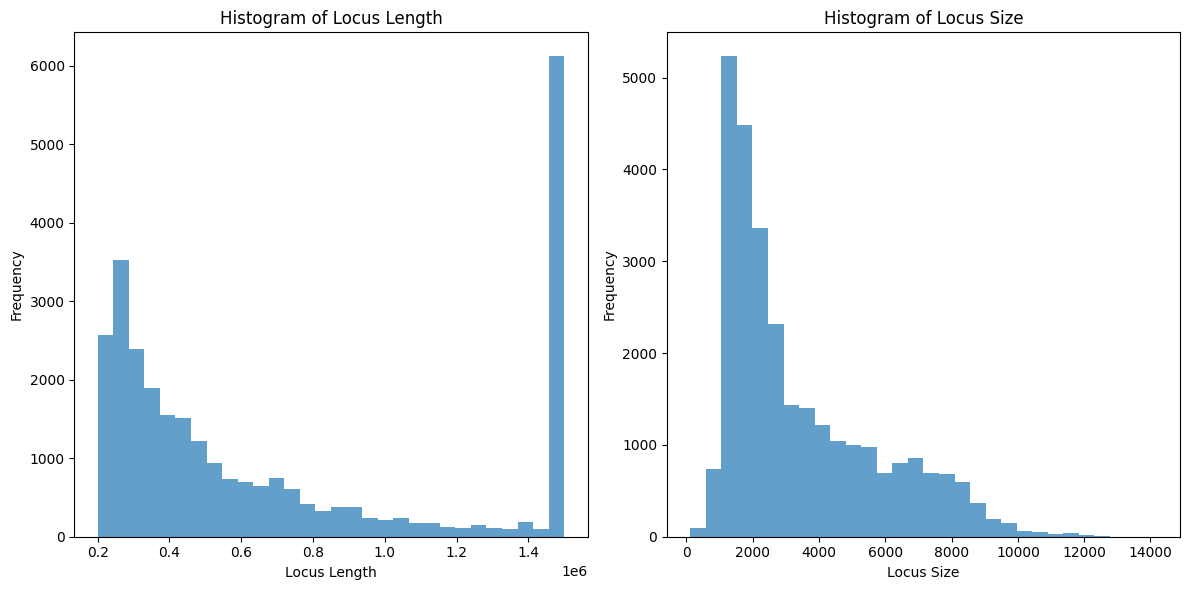

In [8]:
panda_df = df.select("locusSize", "locusLength").toPandas()

plt.figure(figsize=(12, 6))

# Histogram for locusLength
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(panda_df["locusLength"], bins=30, alpha=0.7)
plt.xlabel("Locus Length")
plt.ylabel("Frequency")
plt.title("Histogram of Locus Length")

# Histogram for locusSize
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(panda_df["locusSize"], bins=30, alpha=0.7)
plt.xlabel("Locus Size")
plt.ylabel("Frequency")
plt.title("Histogram of Locus Size")

plt.tight_layout()
plt.show()

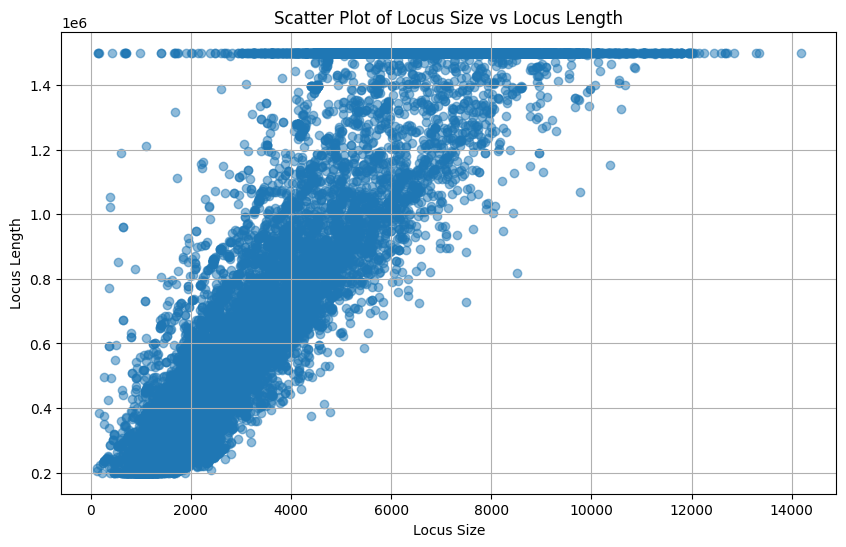

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(panda_df["locusSize"], panda_df["locusLength"], alpha=0.5)
plt.title("Scatter Plot of Locus Size vs Locus Length")
plt.xlabel("Locus Size")
plt.ylabel("Locus Length")
plt.grid(True)
plt.show()

In [29]:
susie_fm = StudyLocus.from_parquet(session, "/Users/dc16/output/ukb_ppp_fm")

Total credible sets:


In [30]:
susie_fm.df.count()

156095

Check for NaN and nulls in the credible set logBF


In [31]:
nan = susie_fm.df.filter(f.isnan("credibleSetlog10BF"))
null = susie_fm.df.filter(f.isnull("credibleSetlog10BF"))
print("Number of credible sets with 'not a number' as the logBF: ", nan.count())
print("Number of credible sets with 'null' as the logBF: ", null.count())

Number of credible sets with 'not a number' as the logBF:  51


Number of credible sets with 'null' as the logBF:  0


In [32]:
susie_results = (
    susie_fm.df.withColumn("credSetSize", f.size("locus"))
    .withColumn(
        "locus",
        f.slice(order_array_of_structs_by_field("locus", "posteriorProbability"), 1, 1)[
            0
        ],
    )
    .withColumn("topPP", f.col("locus").getField("posteriorProbability"))
    .filter(~f.isnan("topPP"))
)
(
    susie_results.select(
        f.mean("topPP").alias("meanTopPP"),
        f.min("topPP").alias("minTopPP"),
        f.percentile_approx("topPP", 0.25).alias("q1TopPP"),
        f.percentile_approx("topPP", 0.5).alias("medianTopPP"),
        f.percentile_approx("topPP", 0.75).alias("q3TopPP"),
        f.max("topPP").alias("maxTopPP"),
    ).show(vertical=True)
)
(
    susie_results.select(
        f.mean("credSetSize").alias("meanCredSetSize"),
        f.min("credSetSize").alias("minCredSetSize"),
        f.percentile_approx("credSetSize", 0.25).alias("q1CredSetSize"),
        f.percentile_approx("credSetSize", 0.5).alias("medianCredSetSize"),
        f.percentile_approx("credSetSize", 0.75).alias("q3CredSetSize"),
        f.max("credSetSize").alias("maxCredSetSize"),
    ).show(vertical=True)
)
(
    susie_results.select(
        f.mean("purityMeanR2").alias("meanPurityMeanR2"),
        f.min("purityMeanR2").alias("minPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.25).alias("q1PurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.5).alias("medianPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.75).alias("q3PurityMeanR2"),
        f.max("purityMeanR2").alias("maxPurityMeanR2"),
    ).show(vertical=True)
)
(
    susie_results.select(
        f.mean("purityMinR2").alias("meanPurityMinR2"),
        f.min("purityMinR2").alias("minPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.25).alias("q1PurityMinR2"),
        f.percentile_approx("purityMinR2", 0.5).alias("medianPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.75).alias("q3PurityMinR2"),
        f.max("purityMinR2").alias("maxPurityMinR2"),
    ).show(vertical=True)
)

-RECORD 0---------------------------
 meanTopPP   | 0.8542130276092752   
 minTopPP    | 0.001186001669897... 
 q1TopPP     | 0.8745159620082537   
 medianTopPP | 0.9999883819186137   
 q3TopPP     | 1.0                  
 maxTopPP    | 1.0                  



-RECORD 0------------------------------
 meanCredSetSize   | 35.91575453077337 
 minCredSetSize    | 1                 
 q1CredSetSize     | 1                 
 medianCredSetSize | 1                 
 q3CredSetSize     | 3                 
 maxCredSetSize    | 8039              



-RECORD 0----------------------------------
 meanPurityMeanR2   | 0.6874051202833201   
 minPurityMeanR2    | 0.007000017286391517 
 q1PurityMeanR2     | 0.33338349079199125  
 medianPurityMeanR2 | 0.9297824652363006   
 q3PurityMeanR2     | 1.0                  
 maxPurityMeanR2    | 1.0                  



-RECORD 0---------------------------------
 meanPurityMinR2   | 0.5521514742672227   
 minPurityMinR2    | 0.0                  
 q1PurityMinR2     | 1.732687240843473E-6 
 medianPurityMinR2 | 0.8141190869307912   
 q3PurityMinR2     | 1.0                  
 maxPurityMinR2    | 1.0                  



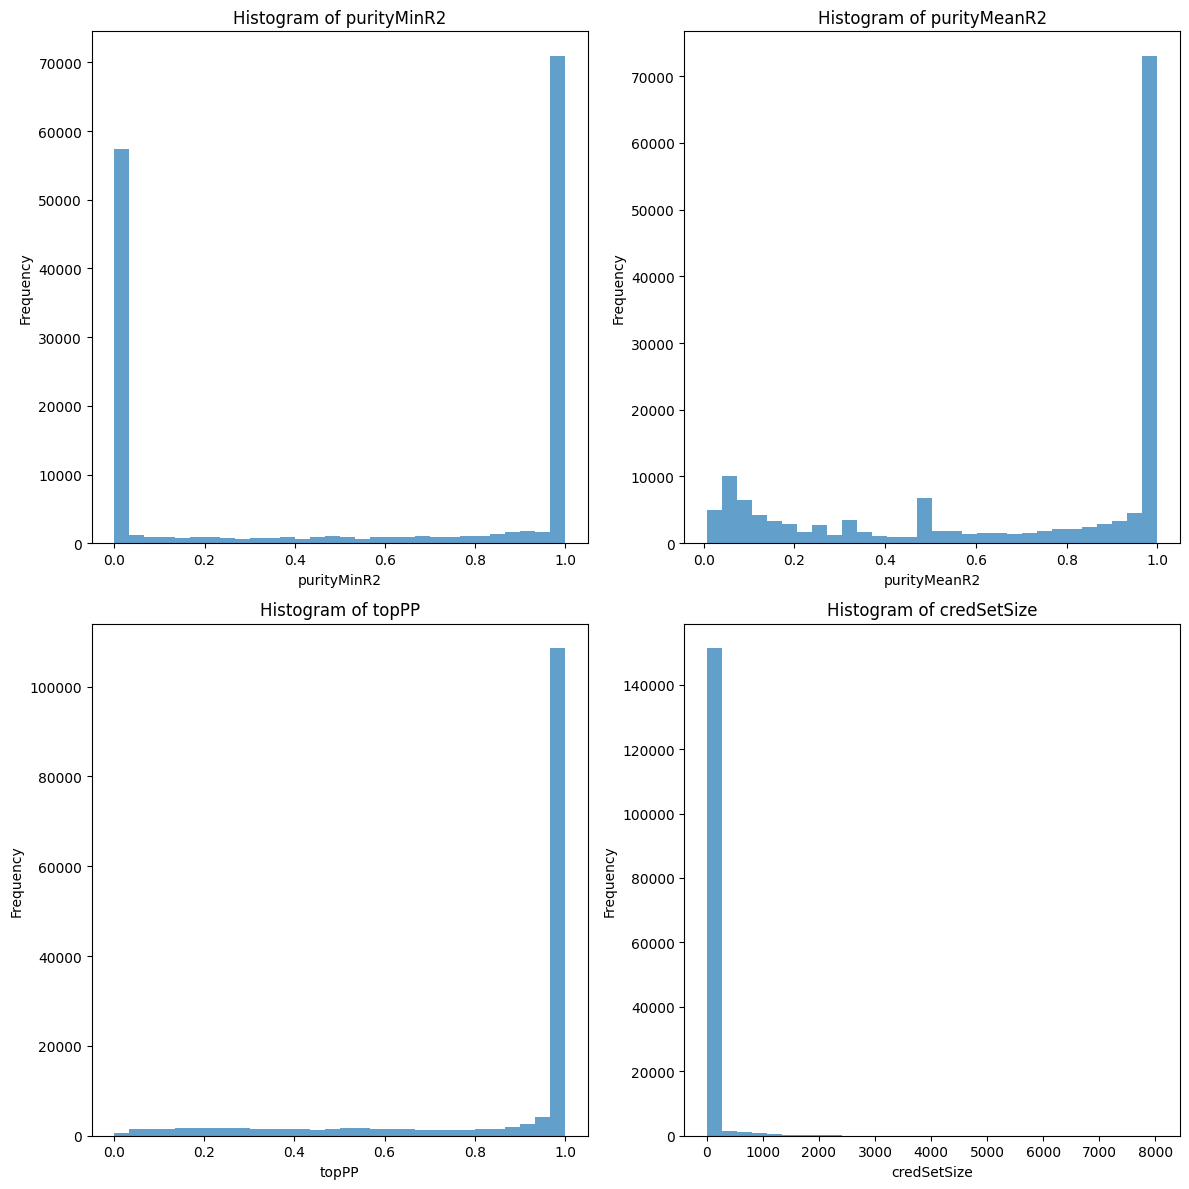

In [33]:
pdf = susie_results.select("purityMinR2", "purityMeanR2", "topPP", "credSetSize").toPandas()
plt.figure(figsize=(12, 12))

# Histogram for purityMinR2
plt.subplot(2, 2, 1)
plt.hist(pdf["purityMinR2"], bins=30, alpha=0.7)
plt.title("Histogram of purityMinR2")
plt.xlabel("purityMinR2")
plt.ylabel("Frequency")

# Histogram for purityMeanR2
plt.subplot(2, 2, 2)
plt.hist(pdf["purityMeanR2"], bins=30, alpha=0.7)
plt.title("Histogram of purityMeanR2")
plt.xlabel("purityMeanR2")
plt.ylabel("Frequency")

# Histogram for topPP
plt.subplot(2, 2, 3)
plt.hist(pdf["topPP"], bins=30, alpha=0.7)
plt.title("Histogram of topPP")
plt.xlabel("topPP")
plt.ylabel("Frequency")

# Histogram for credSetSize
plt.subplot(2, 2, 4)
plt.hist(pdf["credSetSize"], bins=30, alpha=0.7)
plt.title("Histogram of credSetSize")
plt.xlabel("credSetSize")
plt.ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Repeating the same steps, but filtering for only the first credible set

Total number of primary credible sets and number of unique studyIds:


In [34]:
first_credset = susie_results.filter(f.col("credibleSetIndex") == 1)
print("Number of primary credible sets: ", first_credset.count())
print("Number of unique studyIds in primary credible sets: ", first_credset.select("studyId").distinct().count())

Number of primary credible sets:  28505


Number of unique studyIds in primary credible sets:  2532


In [35]:
(
    first_credset.select(
        f.mean("topPP").alias("meanTopPP"),
        f.min("topPP").alias("minTopPP"),
        f.percentile_approx("topPP", 0.25).alias("q1TopPP"),
        f.percentile_approx("topPP", 0.5).alias("medianTopPP"),
        f.percentile_approx("topPP", 0.75).alias("q3TopPP"),
        f.max("topPP").alias("maxTopPP"),
    ).show(vertical=True)
)
(
    first_credset.select(
        f.mean("credSetSize").alias("meanCredSetSize"),
        f.min("credSetSize").alias("minCredSetSize"),
        f.percentile_approx("credSetSize", 0.25).alias("q1CredSetSize"),
        f.percentile_approx("credSetSize", 0.5).alias("medianCredSetSize"),
        f.percentile_approx("credSetSize", 0.75).alias("q3CredSetSize"),
        f.max("credSetSize").alias("maxCredSetSize"),
    ).show(vertical=True)
)
(
    first_credset.select(
        f.mean("purityMeanR2").alias("meanPurityMeanR2"),
        f.min("purityMeanR2").alias("minPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.25).alias("q1PurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.5).alias("medianPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.75).alias("q3PurityMeanR2"),
        f.max("purityMeanR2").alias("maxPurityMeanR2"),
    ).show(vertical=True)
)
(
    first_credset.select(
        f.mean("purityMinR2").alias("meanPurityMinR2"),
        f.min("purityMinR2").alias("minPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.25).alias("q1PurityMinR2"),
        f.percentile_approx("purityMinR2", 0.5).alias("medianPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.75).alias("q3PurityMinR2"),
        f.max("purityMinR2").alias("maxPurityMinR2"),
    ).show(vertical=True)
)

-RECORD 0---------------------------
 meanTopPP   | 0.7889788075318815   
 minTopPP    | 0.001186001669897... 
 q1TopPP     | 0.5742520497939981   
 medianTopPP | 0.9999999979750598   
 q3TopPP     | 1.0                  
 maxTopPP    | 1.0                  



-RECORD 0-------------------------------
 meanCredSetSize   | 30.776039291352394 
 minCredSetSize    | 1                  
 q1CredSetSize     | 1                  
 medianCredSetSize | 1                  
 q3CredSetSize     | 5                  
 maxCredSetSize    | 8039               



-RECORD 0----------------------------------
 meanPurityMeanR2   | 0.6944774658558702   
 minPurityMeanR2    | 0.007000017286391517 
 q1PurityMeanR2     | 0.3800384139391609   
 medianPurityMeanR2 | 0.8792318502960436   
 q3PurityMeanR2     | 1.0                  
 maxPurityMeanR2    | 1.0                  



-RECORD 0---------------------------------
 meanPurityMinR2   | 0.5392208990423786   
 minPurityMinR2    | 0.0                  
 q1PurityMinR2     | 1.082494892946293... 
 medianPurityMinR2 | 0.6362419606887338   
 q3PurityMinR2     | 1.0                  
 maxPurityMinR2    | 1.0                  



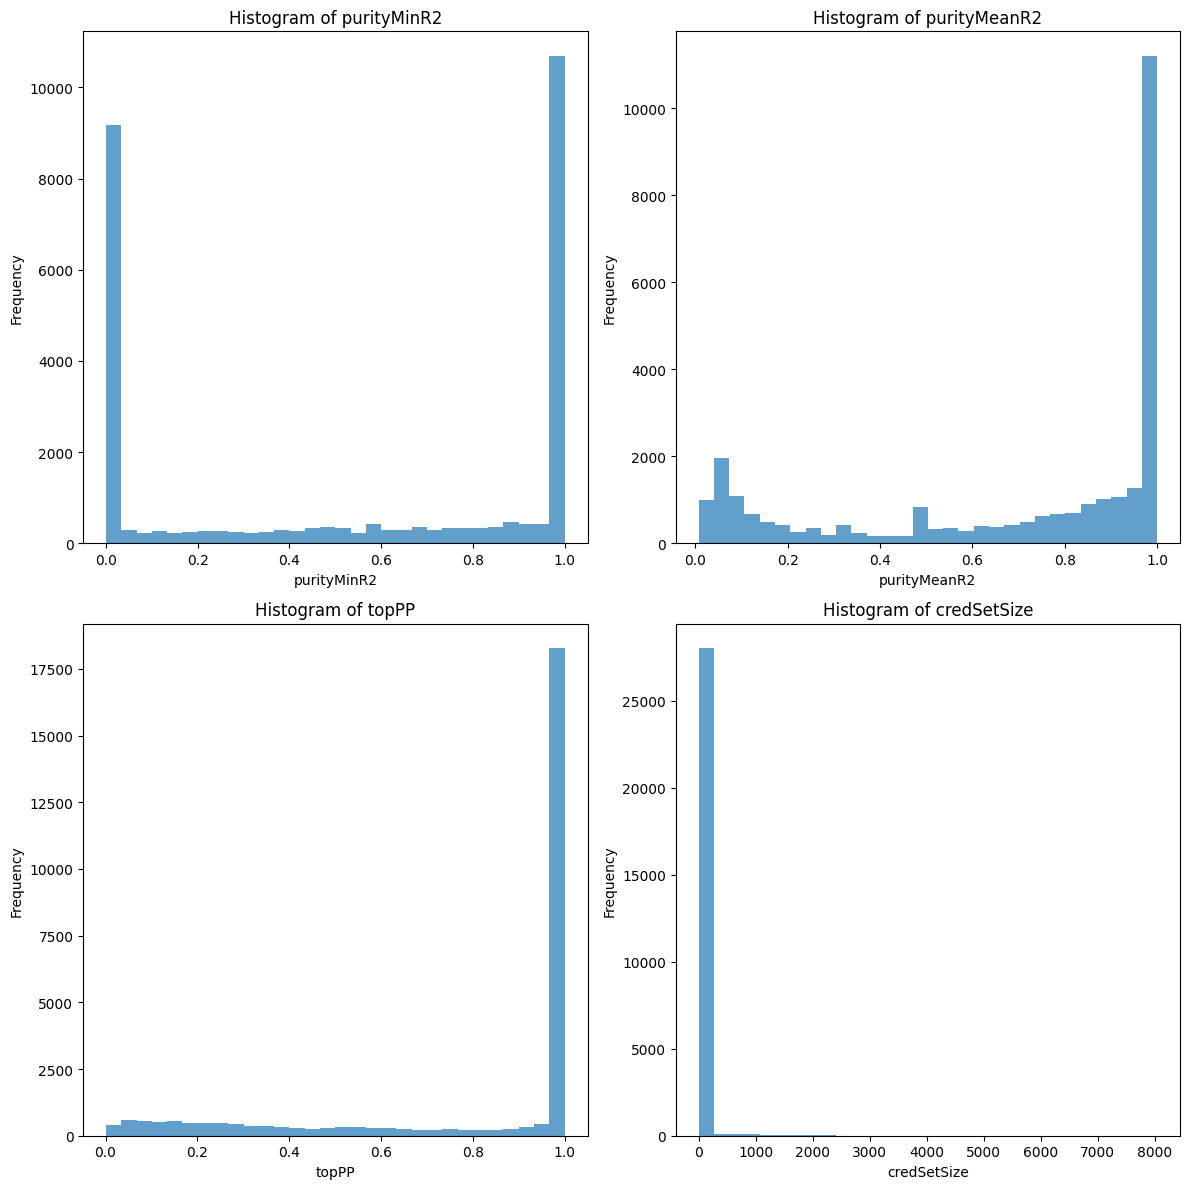

In [36]:
pdf = first_credset.select("purityMinR2", "purityMeanR2", "topPP", "credSetSize").toPandas()
plt.figure(figsize=(12, 12))

# Histogram for purityMinR2
plt.subplot(2, 2, 1)
plt.hist(pdf["purityMinR2"], bins=30, alpha=0.7)
plt.title("Histogram of purityMinR2")
plt.xlabel("purityMinR2")
plt.ylabel("Frequency")

# Histogram for purityMeanR2
plt.subplot(2, 2, 2)
plt.hist(pdf["purityMeanR2"], bins=30, alpha=0.7)
plt.title("Histogram of purityMeanR2")
plt.xlabel("purityMeanR2")
plt.ylabel("Frequency")

# Histogram for topPP
plt.subplot(2, 2, 3)
plt.hist(pdf["topPP"], bins=30, alpha=0.7)
plt.title("Histogram of topPP")
plt.xlabel("topPP")
plt.ylabel("Frequency")

# Histogram for credSetSize
plt.subplot(2, 2, 4)
plt.hist(pdf["credSetSize"], bins=30, alpha=0.7)
plt.title("Histogram of credSetSize")
plt.xlabel("credSetSize")
plt.ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Filtering credible sets with qc function

In [37]:
qc_credsets = SUSIE_inf.credible_set_qc(
    susie_fm, study_index, ld_index, 1e-5, 0.25, 0.8
).persist()

qc_credsets = (
    qc_credsets.df.withColumn("credSetSize", f.size("locus"))
    .withColumn(
        "locus",
        f.slice(order_array_of_structs_by_field("locus", "posteriorProbability"), 1, 1)[
            0
        ],
    )
    .withColumn("topPP", f.col("locus").getField("posteriorProbability"))
    .filter(~f.isnan("topPP"))
)

print("Number of high quality credible sets: ", qc_credsets.count())
print(
    "Number of unique studyIds in high quality credible sets: ",
    qc_credsets.select("studyId").distinct().count(),
)

24/07/25 15:16:04 WARN CacheManager: Asked to cache already cached data.
Number of high quality credible sets:  53866
Number of unique studyIds in high quality credible sets:  2404


In [38]:
(
    qc_credsets.select(
        f.mean("topPP").alias("meanTopPP"),
        f.min("topPP").alias("minTopPP"),
        f.percentile_approx("topPP", 0.25).alias("q1TopPP"),
        f.percentile_approx("topPP", 0.5).alias("medianTopPP"),
        f.percentile_approx("topPP", 0.75).alias("q3TopPP"),
        f.max("topPP").alias("maxTopPP"),
    ).show(vertical=True)
)
(
    qc_credsets.select(
        f.mean("credSetSize").alias("meanCredSetSize"),
        f.min("credSetSize").alias("minCredSetSize"),
        f.percentile_approx("credSetSize", 0.25).alias("q1CredSetSize"),
        f.percentile_approx("credSetSize", 0.5).alias("medianCredSetSize"),
        f.percentile_approx("credSetSize", 0.75).alias("q3CredSetSize"),
        f.max("credSetSize").alias("maxCredSetSize"),
    ).show(vertical=True)
)
(
    qc_credsets.select(
        f.mean("purityMeanR2").alias("meanPurityMeanR2"),
        f.min("purityMeanR2").alias("minPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.25).alias("q1PurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.5).alias("medianPurityMeanR2"),
        f.percentile_approx("purityMeanR2", 0.75).alias("q3PurityMeanR2"),
        f.max("purityMeanR2").alias("maxPurityMeanR2"),
    ).show(vertical=True)
)
(
    qc_credsets.select(
        f.mean("purityMinR2").alias("meanPurityMinR2"),
        f.min("purityMinR2").alias("minPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.25).alias("q1PurityMinR2"),
        f.percentile_approx("purityMinR2", 0.5).alias("medianPurityMinR2"),
        f.percentile_approx("purityMinR2", 0.75).alias("q3PurityMinR2"),
        f.max("purityMinR2").alias("maxPurityMinR2"),
    ).show(vertical=True)
)

-RECORD 0---------------------------
 meanTopPP   | 0.8666990002510717   
 minTopPP    | 0.010513095889158814 
 q1TopPP     | 0.9433303137499335   
 medianTopPP | 0.999999615143476    
 q3TopPP     | 1.0                  
 maxTopPP    | 1.0                  

-RECORD 0------------------------------
 meanCredSetSize   | 4.988601344076041 
 minCredSetSize    | 1                 
 q1CredSetSize     | 1                 
 medianCredSetSize | 1                 
 q3CredSetSize     | 2                 
 maxCredSetSize    | 1141              

-RECORD 0--------------------------------
 meanPurityMeanR2   | 0.9672582865338771 
 minPurityMeanR2    | 0.4799853951628606 
 q1PurityMeanR2     | 0.9911717011644601 
 medianPurityMeanR2 | 1.0                
 q3PurityMeanR2     | 1.0                
 maxPurityMeanR2    | 1.0                

-RECORD 0--------------------------------
 meanPurityMinR2   | 0.9187495682492771  
 minPurityMinR2    | 0.25018750677013313 
 q1PurityMinR2     | 0.98234340232892 

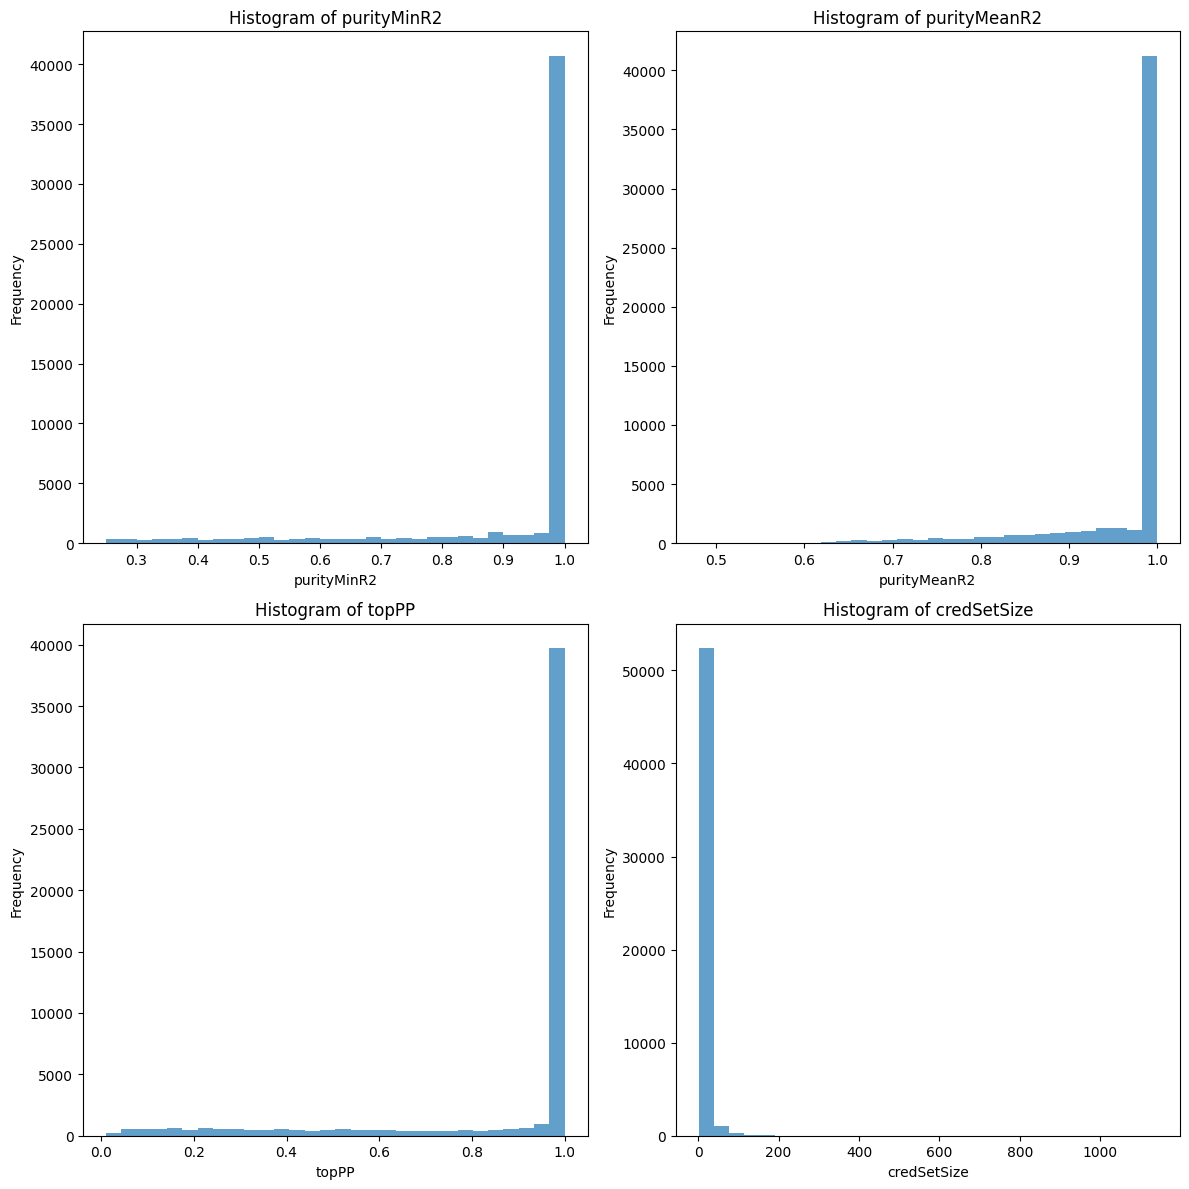

In [39]:
pdf = qc_credsets.select("purityMinR2", "purityMeanR2", "topPP", "credSetSize").toPandas()
plt.figure(figsize=(12, 12))

# Histogram for purityMinR2
plt.subplot(2, 2, 1)
plt.hist(pdf["purityMinR2"], bins=30, alpha=0.7)
plt.title("Histogram of purityMinR2")
plt.xlabel("purityMinR2")
plt.ylabel("Frequency")

# Histogram for purityMeanR2
plt.subplot(2, 2, 2)
plt.hist(pdf["purityMeanR2"], bins=30, alpha=0.7)
plt.title("Histogram of purityMeanR2")
plt.xlabel("purityMeanR2")
plt.ylabel("Frequency")

# Histogram for topPP
plt.subplot(2, 2, 3)
plt.hist(pdf["topPP"], bins=30, alpha=0.7)
plt.title("Histogram of topPP")
plt.xlabel("topPP")
plt.ylabel("Frequency")

# Histogram for credSetSize
plt.subplot(2, 2, 4)
plt.hist(pdf["credSetSize"], bins=30, alpha=0.7)
plt.title("Histogram of credSetSize")
plt.xlabel("credSetSize")
plt.ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# WIP

# Clumped loci filtered for usage with PICS


Number of unique studyIds


In [40]:
pics_loci.df.select("studyId").distinct().count()

15

Number of loci to fine map with PICS


In [41]:
pics_loci.df.count()

18

In [42]:
df = pics_loci.df.withColumns(
    {
        "locusSize": f.size("locus"),
        "locusLength": f.col("locusEnd") - f.col("locusStart"),
    }
)

How many loci with less than 100 variants from summary statistics?


In [43]:
df.filter(f.col("locusSize") < 100).count()

18

How many loci with more than 15,000 variants from summary statistics?


In [44]:
df.filter(f.col("locusSize") > 15_000).count()

0

In [45]:
length = df.select(
    f.mean("locusLength").alias("meanLocusLength"),
    f.percentile_approx("locusLength", 0.25).alias("q1LocusLength"),
    f.percentile_approx("locusLength", 0.5).alias("medianLocusLength"),
    f.percentile_approx("locusLength", 0.75).alias("q3LocusLength"),
)
size = df.select(
    f.mean("locusSize").alias("meanLocusSize"),
    f.min("locusSize").alias("minLocusSize"),
    f.percentile_approx("locusSize", 0.25).alias("q1LocusSize"),
    f.percentile_approx("locusSize", 0.5).alias("medianLocusSize"),
    f.percentile_approx("locusSize", 0.75).alias("q3LocusSize"),
    f.max("locusSize").alias("maxLocusSize"),
)
length.show(vertical=True)
size.show(vertical=True)

-RECORD 0------------------------------
 meanLocusLength   | 273867.6666666667 
 q1LocusLength     | 200000            
 medianLocusLength | 200000            
 q3LocusLength     | 302688            

-RECORD 0-----------------------------
 meanLocusSize   | 30.055555555555557 
 minLocusSize    | 2                  
 q1LocusSize     | 12                 
 medianLocusSize | 19                 
 q3LocusSize     | 57                 
 maxLocusSize    | 79                 



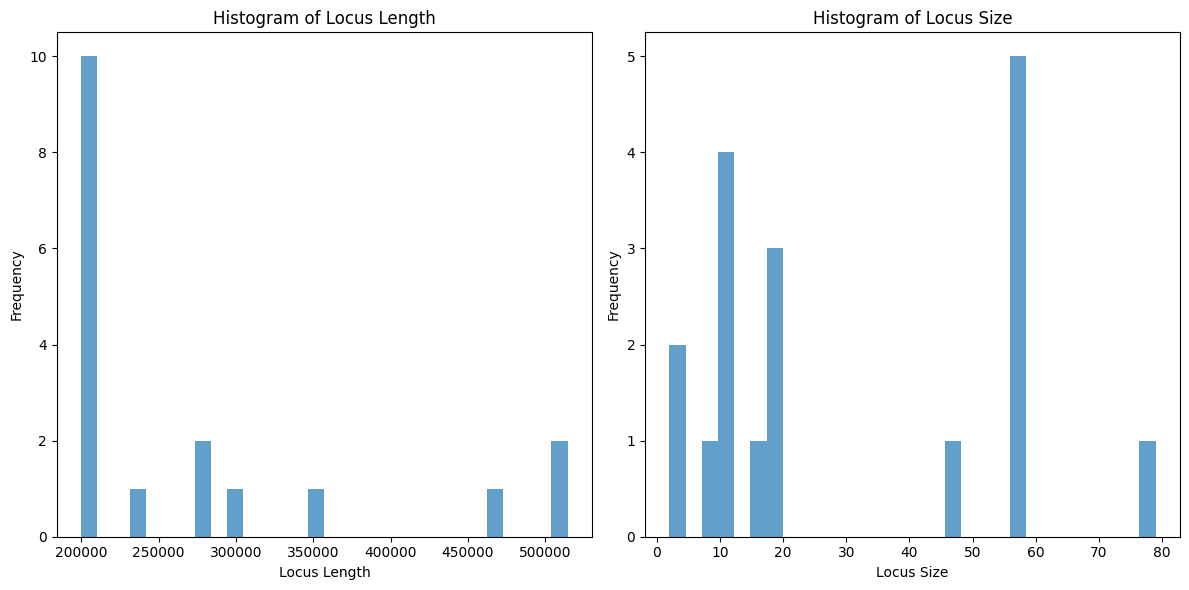

In [46]:
panda_df = df.select("locusSize", "locusLength").toPandas()

plt.figure(figsize=(12, 6))

# Histogram for locusLength
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(panda_df["locusLength"], bins=30, alpha=0.7)
plt.xlabel("Locus Length")
plt.ylabel("Frequency")
plt.title("Histogram of Locus Length")

# Histogram for locusSize
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(panda_df["locusSize"], bins=30, alpha=0.7)
plt.xlabel("Locus Size")
plt.ylabel("Frequency")
plt.title("Histogram of Locus Size")

plt.tight_layout()
plt.show()

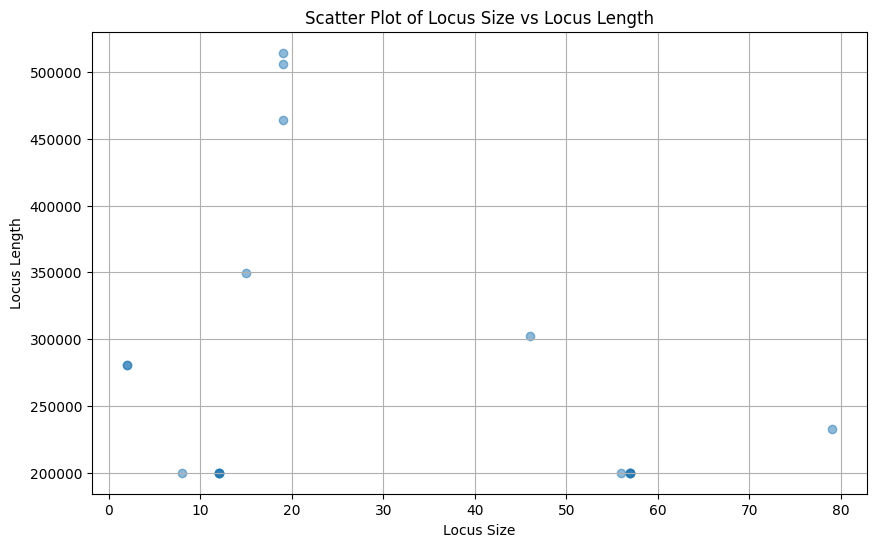

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(panda_df["locusSize"], panda_df["locusLength"], alpha=0.5)
plt.title("Scatter Plot of Locus Size vs Locus Length")
plt.xlabel("Locus Size")
plt.ylabel("Locus Length")
plt.grid(True)
plt.show()